In [143]:
import arviz as az
import matplotlib.pyplot as plt
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

# 個体差と生存種子数（個体差あり）

In [144]:
data = pd.read_csv("./data/section10a.csv")
data.y

0     0
1     2
2     7
3     8
4     1
     ..
95    1
96    0
97    4
98    7
99    0
Name: y, Length: 100, dtype: int64

In [145]:
np.array(data.y)

array([0, 2, 7, 8, 1, 7, 8, 8, 1, 1, 4, 0, 1, 4, 7, 8, 7, 0, 2, 2, 1, 1,
       5, 7, 8, 3, 8, 4, 6, 0, 8, 7, 8, 0, 2, 6, 7, 8, 2, 1, 1, 0, 0, 7,
       8, 5, 7, 2, 8, 1, 5, 7, 3, 8, 0, 8, 6, 3, 2, 0, 0, 1, 2, 8, 7, 7,
       7, 8, 0, 0, 0, 5, 1, 0, 0, 0, 8, 1, 8, 4, 7, 2, 1, 4, 7, 0, 8, 1,
       8, 7, 6, 2, 8, 6, 6, 1, 0, 4, 7, 0])

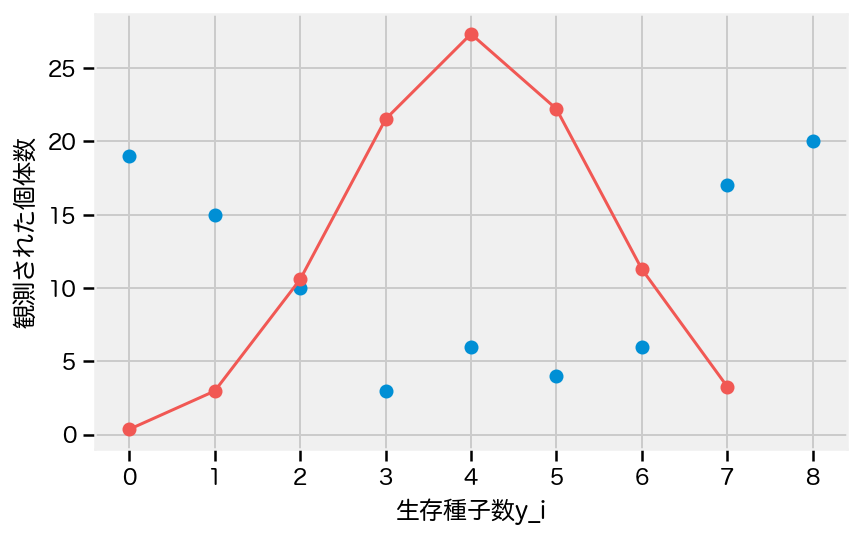

In [146]:
xx, idx, count = tf.unique_with_counts(data.y)
n = 8
plt.scatter(xx, count)
plt.plot(
    np.arange(n), 
    tfd.Binomial(total_count=n, probs=0.504).prob(np.arange(n)) * 100, 
    color=TFColor[0], marker="o")
plt.xlabel("生存種子数y_i")
plt.ylabel("観測された個体数")
plt.show()

In [147]:
with pm.Model() as model:
    y_shared = pm.Data("y_obs", data.y)
    
    beta = pm.Normal("beta", mu=0., sigma=100.)
    es = pm.Uniform("es", lower=0., upper=float(1e4))
    r = pm.Normal("r", mu=0., sigma=es, shape=data.y.shape[0])
    # 1. / (1. + tf.exp(-z))
    logistic = pm.Deterministic("logistic", pm.math.invlogit(beta + r))
    learned_dist = pm.Binomial("learned_dist", n=n, p=logistic, observed=y_shared)

In [148]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, target_accept=0.95, return_inferencedata=True)
    # check convergence diagnostics
    assert all(pm.rhat(trace) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [r, es, beta]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [149]:
with model:
    post_pred = pm.sample_posterior_predictive(trace.posterior)
    trace.extend(az.from_pymc3(posterior_predictive=post_pred))    

In [154]:
with model:
    pm.set_data(
        {
            # use dummy values with the same shape:
            "y_obs": np.zeros(100, dtype=np.int32),
        }
    )        
    sample_from_post = pm.sample_posterior_predictive(trace.posterior)

In [126]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

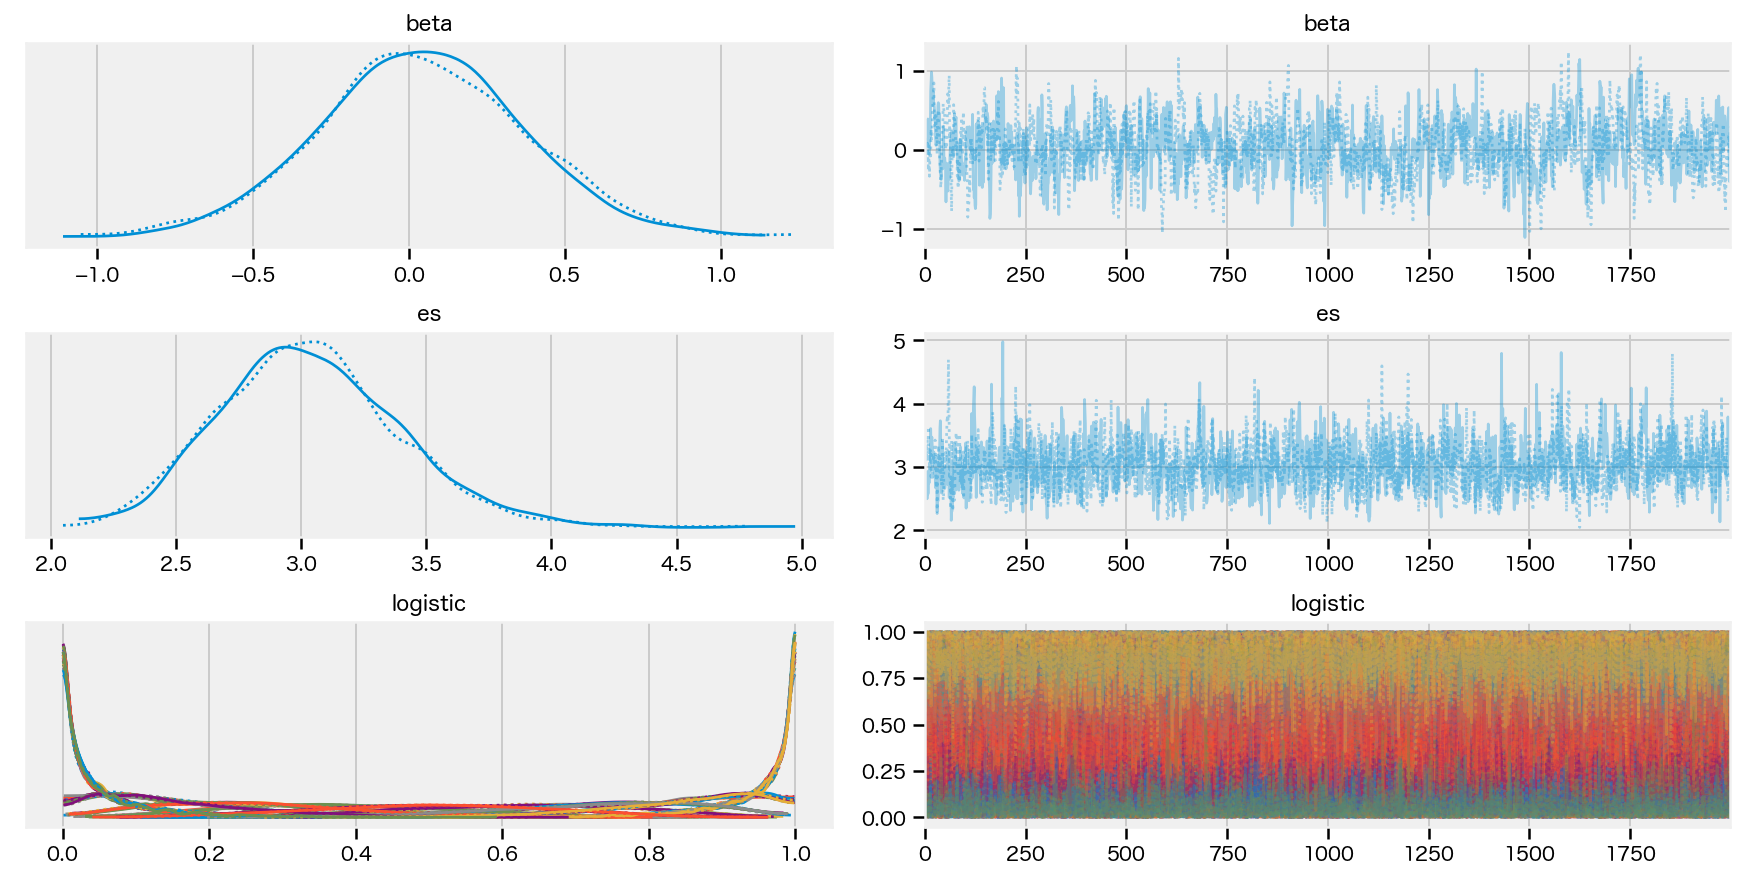

In [128]:
az.plot_trace(trace, var_names=["beta", "es", "logistic"]);

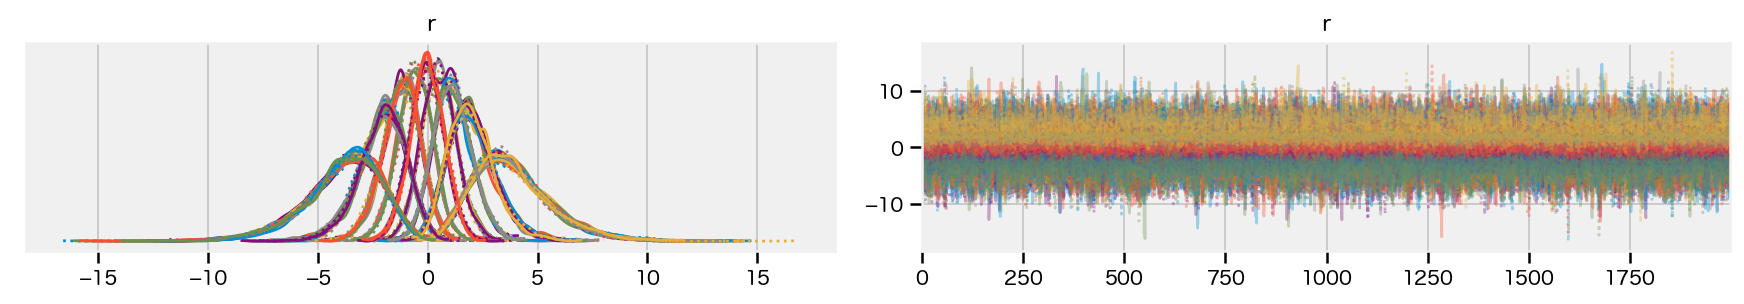

In [129]:
az.plot_trace(trace, var_names=["r"]);

array([<AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'es'}>], dtype=object)

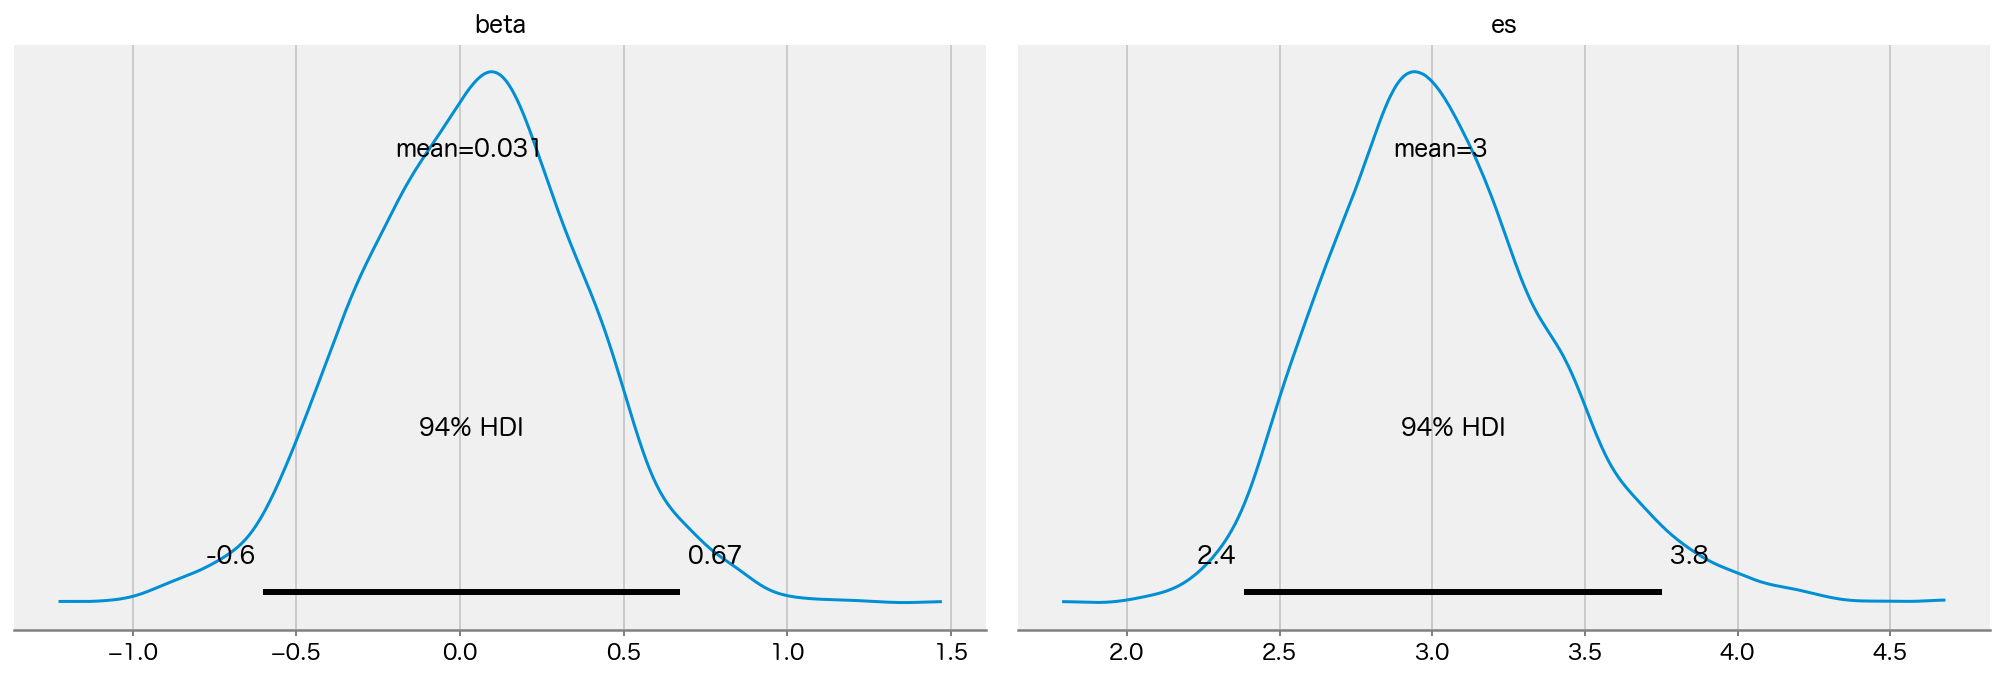

In [111]:
az.plot_posterior(trace, var_names=["beta", "es"])

array([[<AxesSubplot:title={'center':'r\n0'}>,
        <AxesSubplot:title={'center':'r\n1'}>,
        <AxesSubplot:title={'center':'r\n2'}>],
       [<AxesSubplot:title={'center':'r\n3'}>,
        <AxesSubplot:title={'center':'r\n4'}>,
        <AxesSubplot:title={'center':'r\n5'}>]], dtype=object)

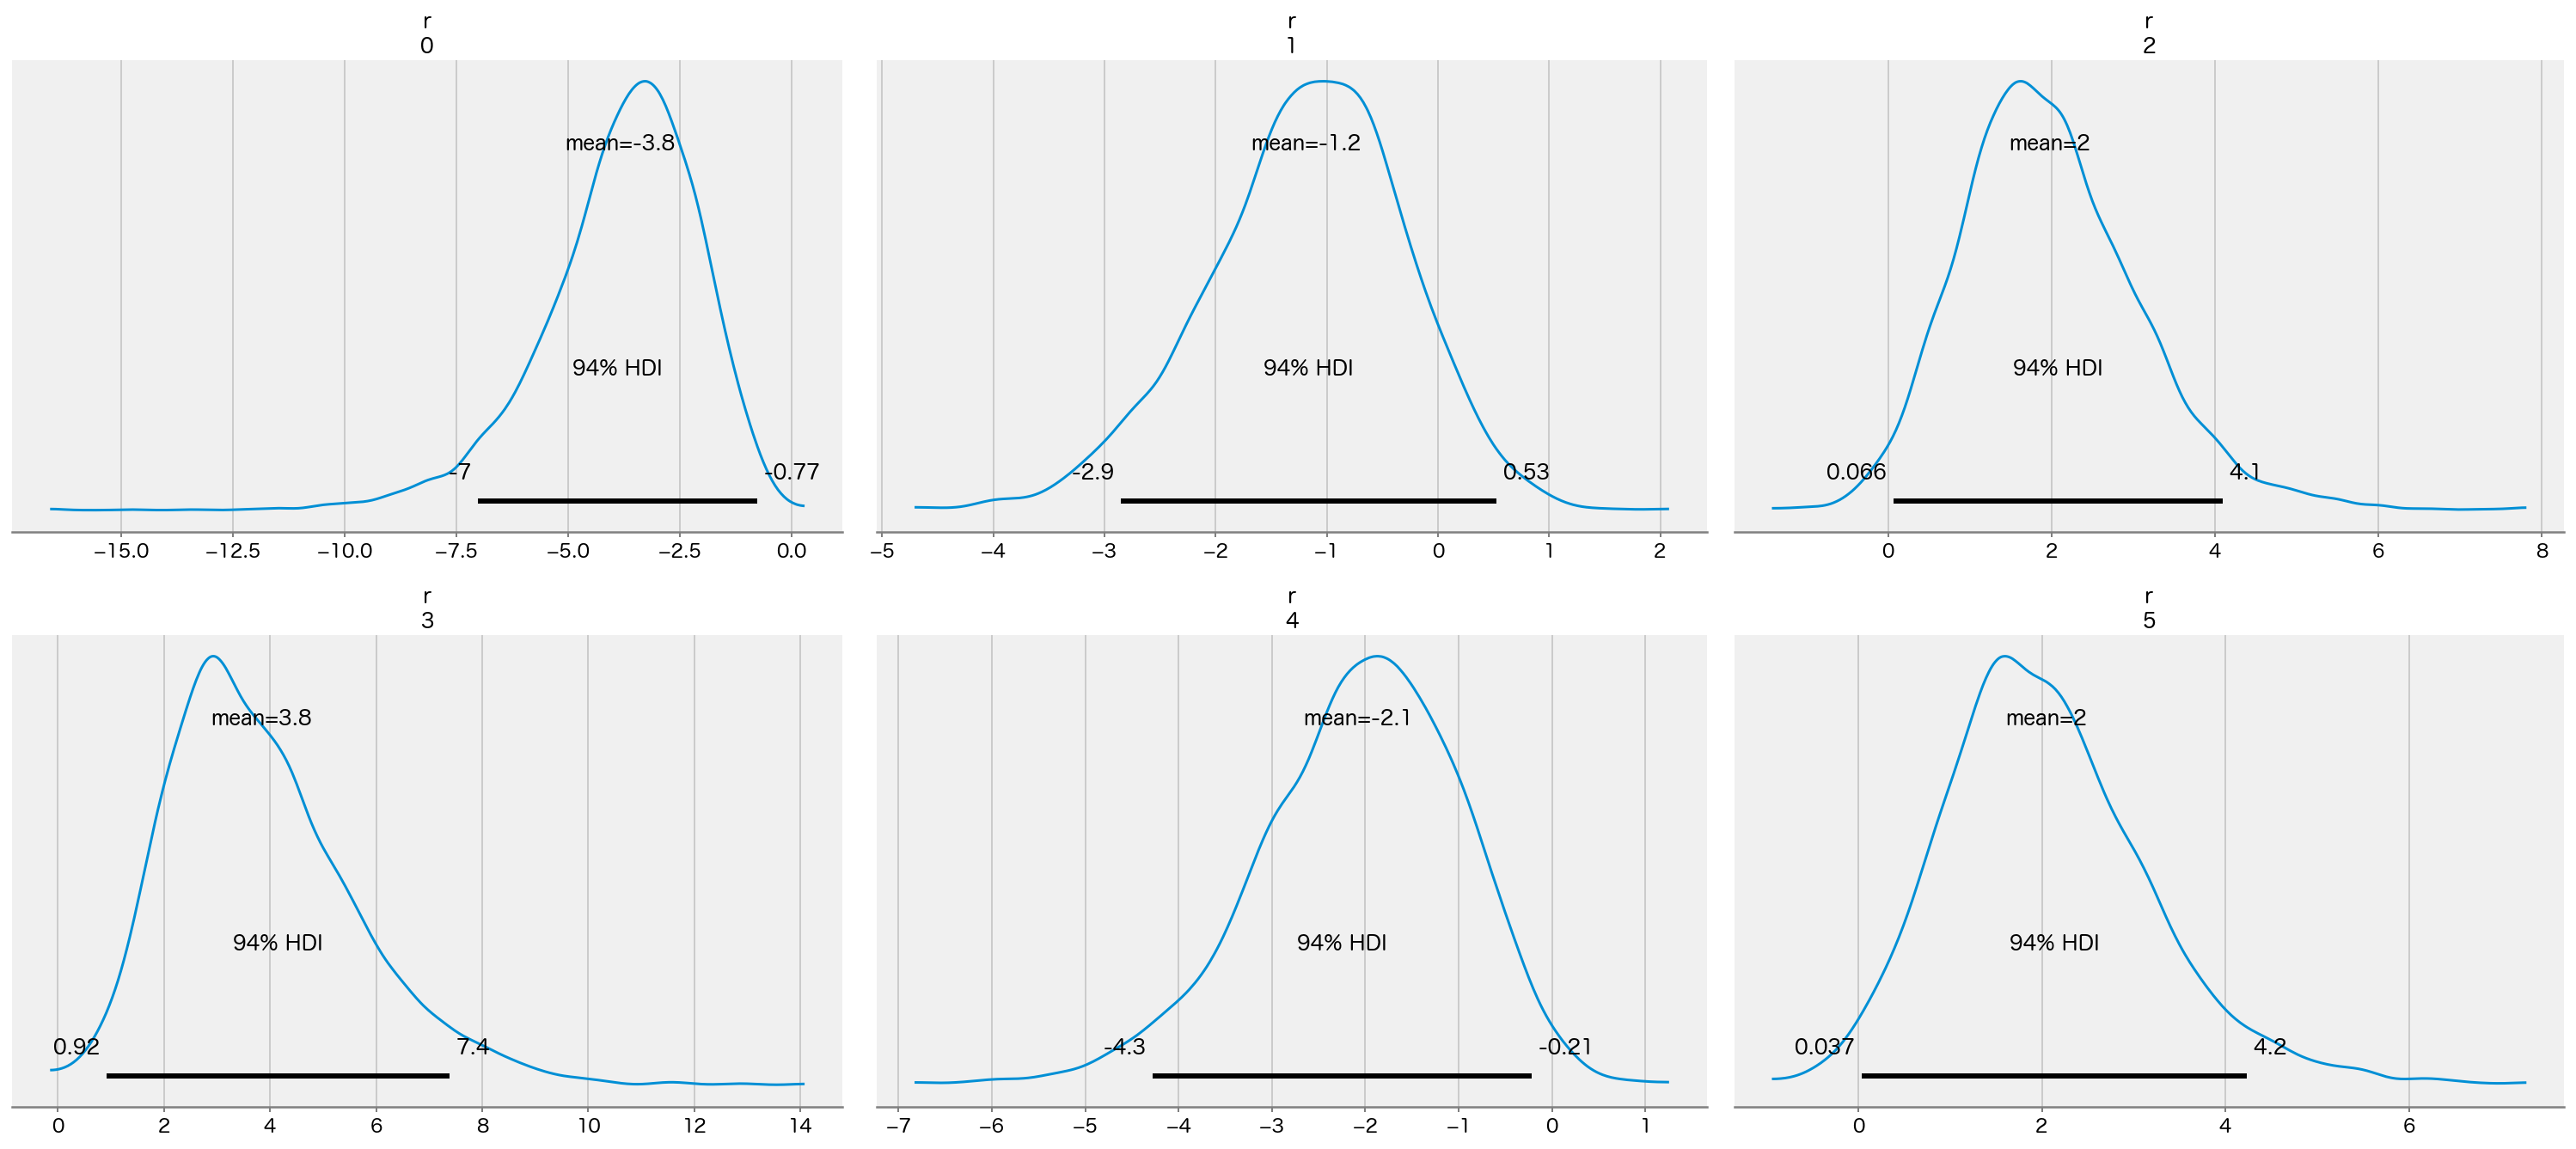

In [130]:
az.plot_posterior(trace, var_names=["r"], coords={'r_dim_0': np.arange(6)})

In [156]:
sample_from_post

{'learned_dist': array([[0, 0, 5, ..., 5, 6, 0],
        [0, 4, 6, ..., 3, 8, 1],
        [0, 3, 7, ..., 3, 7, 0],
        ...,
        [0, 2, 6, ..., 6, 6, 0],
        [0, 0, 8, ..., 2, 7, 0],
        [0, 0, 8, ..., 4, 7, 1]])}

/Users/akira/opt/anaconda3/envs/pymc3/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:title={'center':'learned_dist'}>

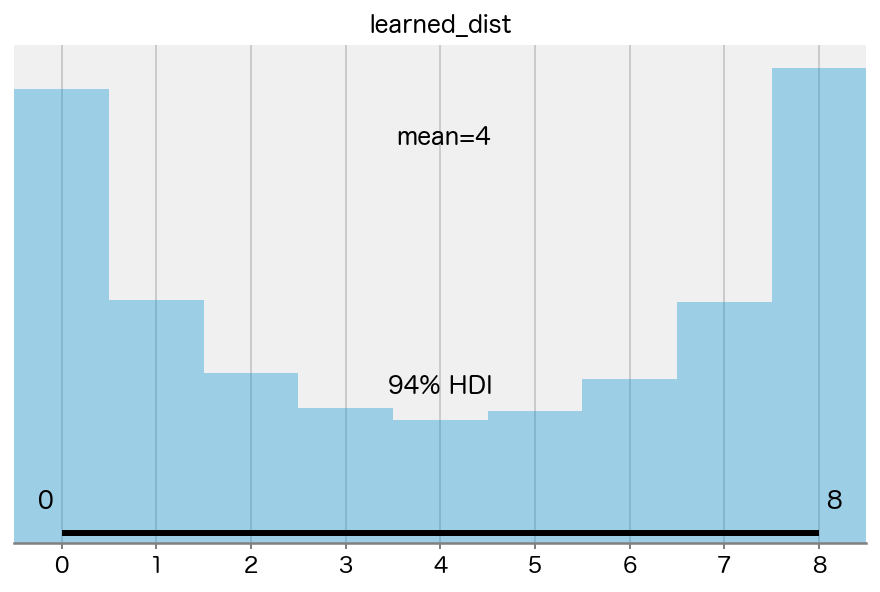

In [155]:
fig, ax = plt.subplots()
az.plot_posterior(sample_from_post)

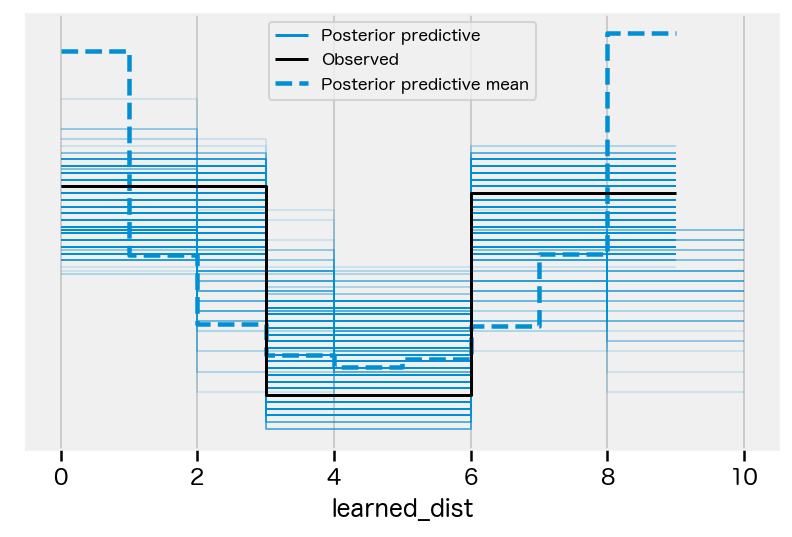

In [131]:
fig, ax = plt.subplots()
az.plot_ppc(trace, ax=ax)
plt.show()

In [114]:
new_arr = arr.reshape(4000, 100)
new_arr.shape

(4000, 100)

# 個体差＋場所差の階層ベイズモデル

In [115]:
data = pd.read_csv("./data/section10b.csv")
data

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0
...,...,...,...,...
95,96,J,T,1
96,97,J,T,1
97,98,J,T,2
98,99,J,T,1


- 切片 => beta1
- 施肥処理 => f (n=100)
- 施肥処理の係数 => beta2
- 個体効果 => r (n=100)
- 植木鉢効果 => t (n=10)


In [ ]:
with pm.Model() as model:
    beta1 = pm.Normal("beta", mu=0., sigma=float(1e-4))
    beta2 = pm.Normal("beta", mu=0., sigma=float(1e-4))
    # es = pm.Uniform("es", lower=0., upper=float(1e4))
    # r = pm.Normal("r", mu=0., sigma=es, shape=data.y.shape[0])
    # lin = beta + r
    # inv_logit = (tt.exp(lin) / (1. + tt.exp(lin)))
    # likelihood = pm.Binomial("likelihood", n=n, p=inv_logit, observed=data.y)